In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torchvision.transforms as tt
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt 
from matplotlib.image import imread
import os
import shutil
import random
from tqdm import tqdm
import math

from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
img_side_length = 128

data_transforms = tt.Compose([tt.Resize(size=(img_side_length, img_side_length)), tt.ToTensor()])

train_dataset = ImageFolder('archive/Training/', transform=data_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

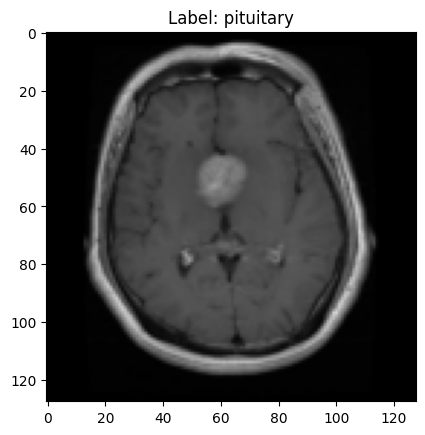

In [4]:
ex_image, ex_label = train_dataset[random.randint(0, len(train_dataset))]

# Switch axes of image array to display
plt.title("Label: " + train_dataset.classes[ex_label])
plt.imshow(ex_image.numpy().transpose(1, 2, 0))




In [5]:
# Making the Model

# Assuming that we input a 128 * 128 * 3 image

class BrainTumorCNN(nn.Module):
    def __init__(self, output_size):
        super(BrainTumorCNN, self).__init__()

        self.output_size = output_size

        # Extracts features from 2D image using Conv2D layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=6, stride=2, padding=1),
            # After this layer, input size is now 16 * 63 * 63
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=8, stride=3, padding=1),
            # After this layer, input size is now 64 * 20 * 20
            nn.ReLU()
        )

        self.input_size = 64 * 20 * 20

        # Linear layers to finish the classification
        self.classifier = nn.Sequential(
            nn.Linear(self.input_size, 2048),
            nn.ReLU(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, self.output_size)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.flatten()
        x = x.view(-1, self.input_size)
        x = self.classifier(x)
        return x




In [6]:
model = BrainTumorCNN(4)
model.to(device)

BrainTumorCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 64, kernel_size=(8, 8), stride=(3, 3), padding=(1, 1))
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=25600, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [7]:
# Choice of loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Training loop
def train_and_test(model, optimizer, loss_function, train_dataloader, test_dataloader, n_epochs):

    train_losses = []
    train_accuracies = []

    test_losses = []
    test_accuracies = []

    for n in range(n_epochs):

        train_correct = 0
        train_total = 0

        for i, (image, label) in enumerate(tqdm(iter(train_dataloader))):
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            model_output = model(image)
            train_loss = loss_function(model_output, label)

            train_loss.backward()
            optimizer.step()

            _, predicted_label = torch.max(model_output, 1)
            train_total += label.size(0)
            train_correct += (predicted_label == label).sum().item()

        train_losses.append(train_loss.item())
        train_accuracy = train_correct / train_total
        train_accuracies.append(train_accuracy)

        with torch.no_grad():

            sum_test_loss = 0
            test_correct = 0
            test_total = 0

            for i, (image, label) in enumerate(tqdm(iter(test_dataloader))):
                image, label = image.to(device), label.to(device)
                output = model(image)
                test_loss = loss_function(output, label)
                sum_test_loss += test_loss.item()

                _, pred = torch.max(output, 1)
                test_total += label.size(0)
                test_correct += (pred == label).sum().item()

            avg_test_loss = sum_test_loss / len(test_dataloader)
            test_losses.append(avg_test_loss)
            test_accuracy = test_correct / test_total
            test_accuracies.append(test_accuracy)
            

    return model, train_losses, train_accuracies, test_losses, test_accuracies

In [9]:
test_dataset = ImageFolder('archive/Testing/', transform=data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Training and Hyperparameter Tuning
lr = 0.001
num_epochs = 10
batch_size = 32

trained_model, train_losses, train_accuracies, test_losses, test_accuracies = train_and_test(model, optimizer, loss_function, train_dataloader, test_dataloader, n_epochs=num_epochs)


100%|██████████| 41/41 [00:05<00:00,  7.45it/s]


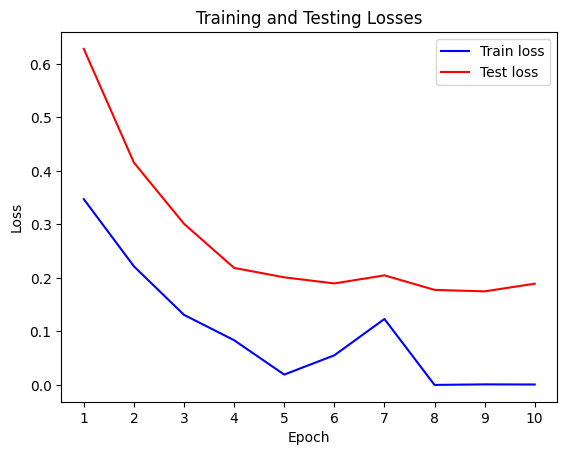

In [20]:
plt.plot(np.arange(1, num_epochs + 1, step=1), train_losses, color='b', label='Train loss')
plt.plot(np.arange(1, num_epochs + 1, step=1), test_losses, color='r', label='Test loss')
plt.xticks(np.arange(1, num_epochs + 1, step=1))
plt.legend()
plt.title("Training and Testing Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

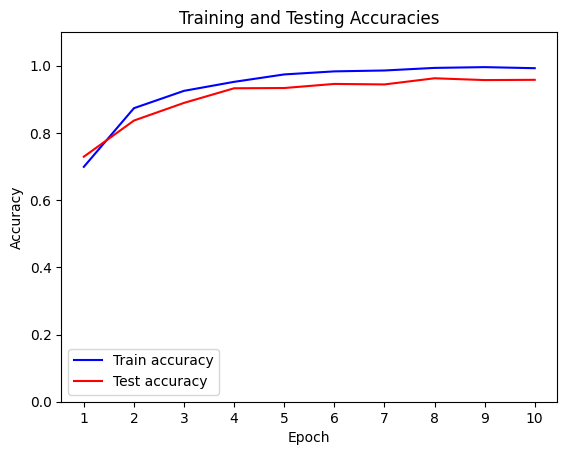

In [19]:
x = np.arange(1, num_epochs + 1, step=1)

plt.plot(x, train_accuracies, color='b', label='Train accuracy')
plt.plot(x, test_accuracies, color='r', label='Test accuracy')
plt.legend()
plt.xticks(np.arange(1, num_epochs + 1, step=1))
plt.title("Training and Testing Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

ax = plt.gca()
ax.set_ylim([0,1.1])

plt.show()



Predicted Label:  pituitary
Actual Label:  pituitary


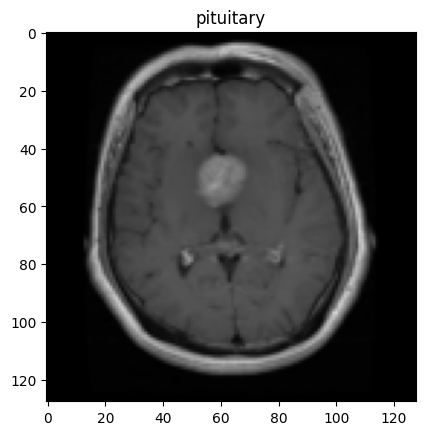

In [15]:
ex_image_output = trained_model(ex_image)
_, ex_image_prediction = torch.max(ex_image_output, 1)
plt.title(train_dataset.classes[ex_label])
plt.imshow(ex_image.numpy().transpose(1, 2, 0))
print("Predicted Label: ", train_dataset.classes[int(ex_image_prediction)])
print("Actual Label: ", train_dataset.classes[ex_label])

In [17]:
print(f"Test Loss: {test_losses[len(test_losses) - 1]:.2}")
print(f"Test Accuracy: {test_accuracies[len(test_accuracies) - 1]:.2%}")

Test Loss: 0.19
Test Accuracy: 95.80%
